## Problem Statement

We have been given a PDE: $u_{xx}+0.49\sin(0.7x)+2.25\cos(1.5x)=0,\quad x\in[-10,10]$
and boundary condition: $u(x)=\hat{u}(x)$

- Independent variables: x (input)
- Dependent variables: u (outputs)


We have to find out u(x) for all x in range [-10,10] 


When we solved this problem analytically, we found the solution: $u(x) = \sin(0.7x)+\cos(1.5x)-0.1x$


Our residual is $f = u_{xx}+0.49\sin(0.7x)+2.25\cos(1.5x)$

In [1]:
import torch
import torch.nn as nn
from torch.autograd import Variable
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [2]:
from tqdm import tqdm, trange
import numpy as np
import matplotlib.pyplot as plt
import time

In [3]:
seed = 1369
torch.set_default_dtype(torch.float)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)

In [4]:
class Net(nn.Module):
    def __init__(self, layers):
        super(Net, self).__init__()
        self.layers = layers
        self.activation = nn.Tanh()
        self.linear = nn.ModuleList([nn.Linear(layers[i], layers[i + 1]) for i in range(len(layers) - 1)])
        for i in range(len(layers) - 1):
            nn.init.xavier_normal_(self.linear[i].weight.data, gain=1.0)
            nn.init.zeros_(self.linear[i].bias.data)

    def forward(self, x):
        if not torch.is_tensor(x):
            x = torch.from_numpy(x)
        a = x
        for i in range(len(self.layers) - 2):
            z = self.linear[i](a)
            a = self.activation(z)
        a = self.linear[-1](a)
        return a

In [5]:
# # We consider Net as our solution u_theta(x)

# """
# When forming the network, we have to keep in mind the number of inputs and outputs
# In ur case: #inputs = 1 (x)
# and #outputs = 1 (u)

# You can add ass many hidden layers as you want with as many neurons.
# More complex the network, the more prepared it is to find complex solutions, but it also requires more data.

# Let us create this network:
# min 3 hidden layer with 50 neurons each.
# """

# class Net(nn.Module):
#     def __init__(self):
#         super(Net, self).__init__()
#         self.activation = nn.Tanh()
#         self.hidden_layer1 = nn.Linear(1,50)
#         self.hidden_layer2 = nn.Linear(50,50)
#         self.hidden_layer3 = nn.Linear(50,50)
#         self.output_layer = nn.Linear(50,1)

#     def forward(self, x):
#         inputs = x # combined two arrays of 1 columns each to one array of 2 columns
#         layer1_out = self.activation(self.hidden_layer1(inputs))
#         layer2_out = self.activation(self.hidden_layer2(layer1_out))
#         layer3_out = self.activation(self.hidden_layer3(layer2_out))
#         output = self.output_layer(layer3_out) ## For regression, no activation is used in output layer
#         return output

In [6]:
use_gpu = torch.cuda.is_available()
print('GPU:', use_gpu)

GPU: True


In [7]:
def is_cuda(data):
    if use_gpu:
        data = data.cuda()
    return data

In [8]:
## residual as loss function. 
def f(x, train_U):
    if not x.requires_grad:
        x = Variable(x, requires_grad=True)
    u = train_U(x) # the dependent variable u is given by the network based on independent variables x
    u_x = torch.autograd.grad(u.sum(), x, create_graph=True)[0]
    u_xx = torch.autograd.grad(u_x.sum(), x, create_graph=True)[0]
    pde = u_xx + 0.49*torch.sin(0.7*x) + 2.25*torch.cos(1.5*x)
    return pde

In [9]:
def exact_U(x):
    return np.sin(0.7*x)+np.cos(1.5*x)-0.1*x 

In [10]:
# mse_cost_function = nn.MSELoss()

In [11]:
class Model:
    def __init__(self, net, iterations, f, x_bc, u_bc, Nf, x_test, x_test_exact, model_type):
        self.x_bc_s = None
        self.x_f_s = None
        self.s_collect = []
        
        self.f = f        
        self.x_bc = x_bc
        self.u_bc = u_bc
        self.Nf = Nf
        
        self.x_test = is_cuda(torch.from_numpy(x_test).float())
        self.x_test_exact = is_cuda(torch.from_numpy(x_test_exact).float())
        
        self.x_col = None
        self.exact_u = None
        self.net = net
        self.iterations = iterations
        self.model_type=model_type
        
        self.Step = []
        self.T_error = []
        self.V_error = []
        self.T_BC = []
        self.T_PDE = []
    
    def train_U(self, x):
        return self.net(x)

    def predict_U(self, x):
        return self.train_U(x)
    
    def epoch_loss(self):
#         loss_bc = mse_cost_function(self.train_U(self.x_bc).to(device), self.u_bc.to(device))
#         loss_pde = mse_cost_function(self.f(self.x_col, self.train_U).to(device), torch.zeros(self.x_col.size()).to(device))
        loss_pde = torch.mean(self.f(self.x_col, self.train_U) ** 2)
        loss_bc = torch.mean((self.train_U(self.x_bc) - self.u_bc) ** 2)
        self.T_PDE.append(loss_pde.item())
        self.T_BC.append(loss_bc.item())
        return loss_pde, loss_bc

    def likelihood_loss(self, loss_f, loss_b):
        loss =  torch.reciprocal(2 * self.x_f_s * self.x_f_s) * loss_f.detach() + torch.log(self.x_f_s) \
              + torch.reciprocal(2 * self.x_bc_s * self.x_bc_s) * loss_b.detach() + torch.log(self.x_bc_s)
        return loss

    def updated_loss(self, loss_f, loss_b):
        loss = torch.reciprocal(self.x_f_s.detach() ** 2) * loss_f \
             + torch.reciprocal(self.x_bc_s.detach() ** 2) * loss_b 
        return loss
    
    def evaluate(self):
        pred = self.train_U(self.x_test).cpu().detach().numpy()
        exact = self.x_test_exact.cpu().detach().numpy()
        error = np.linalg.norm(pred - exact, 2) / np.linalg.norm(exact, 2)
        return error
    
    def run_PINN(self):
        optimizer = torch.optim.Adam(self.net.parameters(), lr=1e-3)       
        pbar = trange(self.iterations, ncols=100)
        for i in pbar:
            self.x_col = np.random.uniform(low=-10.0, high=10.0, size=(self.Nf,1))
            self.exact_u=exact_U(self.x_col)
            self.x_col=is_cuda(torch.from_numpy(self.x_col).float())
            self.exact_u=is_cuda(torch.from_numpy(self.exact_u).float())
            loss_pde, loss_bc = self.epoch_loss()    
            optimizer.zero_grad()
            loss = loss_pde + loss_bc
            loss.backward()
            optimizer.step()
            pbar.set_postfix({'Iter': i,
                            'Loss': '{0:.2e}'.format(loss.item()),
                            'PDE': '{0:.2e}'.format(loss_pde.item()),
                            'BC': '{0:.2e}'.format(loss_bc.item())
                                  })
            with torch.autograd.no_grad():
                self.T_error.append(loss.item())
                l2_loss = self.evaluate()
                self.V_error.append(l2_loss.item())
                self.Step.append(i)

                
    def run_lbPINN(self):
        self.x_f_s = nn.Parameter(self.x_f_s, requires_grad=True)
        self.x_bc_s = nn.Parameter(self.x_bc_s, requires_grad=True)

        optimizer_weight = torch.optim.Adam([self.x_f_s] + [self.x_bc_s],lr=1e-3)
        optimizer = torch.optim.Adam(self.net.parameters(), lr=1e-3)
        
        pbar = trange(self.iterations, ncols=100)

        for i in pbar:
            self.x_col = np.random.uniform(low=-10.0, high=10.0, size=(self.Nf,1))
            self.exact_u=exact_U(self.x_col)
            self.x_col=is_cuda(torch.from_numpy(self.x_col).float())
            self.exact_u=is_cuda(torch.from_numpy(self.exact_u).float())
            self.s_collect.append([self.x_f_s.item(), self.x_bc_s.item()])
            loss_pde, loss_bc = self.epoch_loss() 
            
            optimizer_weight.zero_grad()
            loss = self.likelihood_loss(loss_pde,loss_bc)
            loss.backward() 
            optimizer_weight.step()
            
            optimizer.zero_grad()
            loss = self.updated_loss(loss_pde,loss_bc)
            loss.backward()
            optimizer.step()
            pbar.set_postfix({'Iter': i,
                            'Loss': '{0:.2e}'.format(loss.item()),
                            'PDE': '{0:.2e}'.format(loss_pde.item()),
                            'BC': '{0:.2e}'.format(loss_bc.item())
                                  })
            
            with torch.autograd.no_grad():
                l2_loss = self.evaluate()
                self.V_error.append(l2_loss.item())
                self.Step.append(i)
        
    def train(self):
#         self.x_col = np.random.uniform(low=-10.0, high=10.0, size=(self.Nf,1))
#         self.exact_u=exact_U(self.x_col)
#         self.x_col=is_cuda(torch.from_numpy(self.x_col).float())
#         self.exact_u=is_cuda(torch.from_numpy(self.exact_u).float())
        start_time = time.time()
        if self.model_type == 0:
            self.run_PINN()
        elif self.model_type == 1:
            self.x_f_s = is_cuda(torch.tensor(.02).float())
            self.x_bc_s = is_cuda(torch.tensor(2.).float())
            self.run_lbPINN()
        elapsed = time.time() - start_time
        print('Training time: %.2f' % elapsed)

In [12]:
def draw_exact(model):
    x=np.arange(-10,10,0.02).reshape((1000,1)) 
    pt_x = Variable(torch.from_numpy(x).float(), requires_grad=True).to(device)
    pt_u = model.predict_U(pt_x)
    plt.plot(x,pt_u.data.cpu().numpy(), label='predicted')
    plt.plot(x,exact_U(x), label='exact')
    plt.legend(frameon=False,fontsize=15)
    plt.show()

In [13]:
def draw_Terror(model):
    ### Plotting the training error
    fig = plt.figure(1)
    ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
    plt.title("Training Error plot",fontsize=15) 
    plt.semilogy(model.Step, model.T_error)
    plt.xlabel(r'iterations',fontsize=15)
    plt.ylabel(r'$MSE_{PDE}+MSE_{BC}$',fontsize=15)
    plt.show()

In [14]:
def draw_Verror(model):
    ### Plotting the validation error
    fig = plt.figure(1)
    ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
    plt.title("Validation Error plot",fontsize=15) 
    plt.semilogy(model.Step, model.V_error)
    plt.xlabel('iterations',fontsize=15)
    plt.ylabel(r'$l_2$',fontsize=15)
    plt.show()

In [15]:
def draw_epoch_loss(model):
    fig = plt.figure(1)
    ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
    plt.title("Error plot",fontsize=15) 
    plt.semilogy(model.Step, model.T_PDE,'b',label=r'$Loss_{PDE}$')
    plt.semilogy(model.Step, model.T_BC,'r',label=r'$Loss_{BC}$')
    plt.xlabel(r'Training times $n$',fontsize=15)
    plt.ylabel(r'$Loss$',fontsize=15)
    plt.legend(frameon=False,fontsize=15)

In [16]:
def draw_epoch_e(model):
    s_collect = np.array(model.s_collect)
    plt.yscale('log')
    plt.plot(np.array(model.Step), s_collect[:, 0], 'b-', label=r'$\epsilon_f$')
    plt.plot(np.array(model.Step), s_collect[:, 1], 'r-', label=r'$\epsilon_{bc}$')
    plt.xlabel('$Iters$')
    plt.ylabel('$\epsilon$')
    plt.legend()
    plt.show()

In [17]:
def draw_epoch_w(model):
    s_collect = np.array(model.s_collect)
    plt.yscale('log')
    plt.plot(np.array(model.Step), np.reciprocal(2*s_collect[:, 0]**2), 'b-', label=r'$\omega_f$')
    plt.plot(np.array(model.Step), np.reciprocal(2*s_collect[:, 1]**2), 'r-', label=r'$\omega_{bc}$')
    plt.xlabel('$Iters$')
    plt.ylabel('$\omega$')
    plt.legend()
    plt.show()

In [18]:
x_bc = np.array([[-10],[10]])
u_bc = exact_U(x_bc)
x_bc=is_cuda(torch.from_numpy(x_bc).float())
u_bc=is_cuda(torch.from_numpy(u_bc).float())

# x_collocation = np.random.uniform(low=-10.0, high=10.0, size=(400,1))
# exact_u= exact_U(x_collocation)
# x_col=is_cuda(torch.from_numpy(x_collocation).float())
# exact_u=is_cuda(torch.from_numpy(exact_u).float())

Nf = 400
x_test = np.linspace(-10.0,10.0,100).reshape((100,1))
x_test_exact = exact_U(x_test)

nIters=5000
layers = [1, 50, 50, 50, 1]

# PINN

In [19]:
net = Net(layers)
# net = Net()
net = net.to(device)

model_type = 0 # 0:PINN  1:lbPINN
model = Model(
    net=net, iterations = nIters, f=f, x_bc=x_bc, u_bc=u_bc , Nf=Nf, x_test=x_test, x_test_exact=x_test_exact, model_type=model_type)

In [20]:
from prettytable import PrettyTable

In [21]:
def count_parameters(model):
    table = PrettyTable(["Modules", "Parameters"])
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad: continue
        params = parameter.numel()
        table.add_row([name, params])
        total_params+=params
    print(table)
    print(f"Total Trainable Params: {total_params}")
    return total_params

In [22]:
count_parameters(net)

+-----------------+------------+
|     Modules     | Parameters |
+-----------------+------------+
| linear.0.weight |     50     |
|  linear.0.bias  |     50     |
| linear.1.weight |    2500    |
|  linear.1.bias  |     50     |
| linear.2.weight |    2500    |
|  linear.2.bias  |     50     |
| linear.3.weight |     50     |
|  linear.3.bias  |     1      |
+-----------------+------------+
Total Trainable Params: 5251


5251

In [23]:
model.train()

100%|█████| 5000/5000 [00:25<00:00, 198.95it/s, Iter=4999, Loss=8.74e-04, PDE=8.26e-04, BC=4.82e-05]

Training time: 25.13


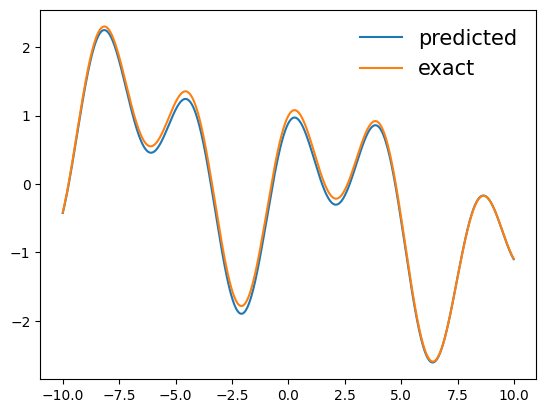

In [24]:
draw_exact(model)

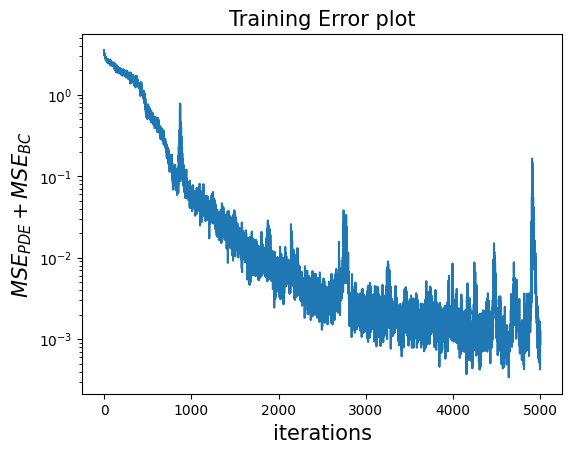

In [25]:
draw_Terror(model)

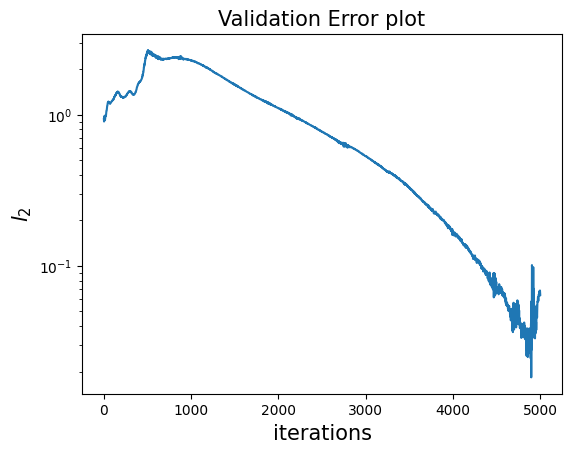

In [26]:
draw_Verror(model)

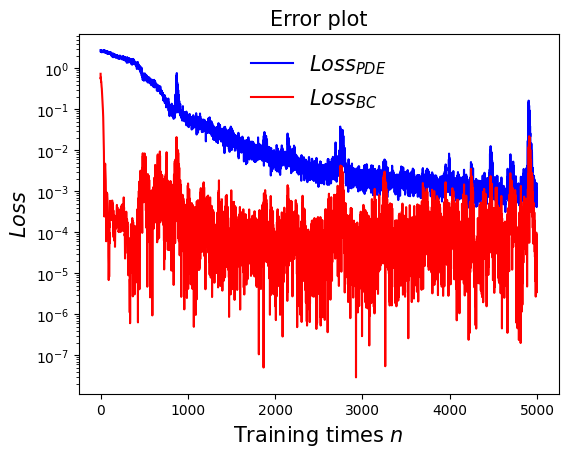

In [27]:
draw_epoch_loss(model)